# Разработка модели машинного обучения для интернет-магазин «В один клик» 

Заказчик исследования — интернет-магазин «В один клик».

Цель работы — разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

In [1]:
# импортируем необходимые библиотеки
import warnings
from datetime import date, timedelta

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import shap
from phik.report import plot_correlation_matrix
from phik import phik_matrix

warnings.simplefilter('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# вспомогательные ф-ции
def visit_times_last_year(x: int) -> int:
    current_year: int = date.today().year
    delta: int = x - (date.today() - date(current_year, 1, 1)).days
    days_of_last_year: int = (date(current_year, 1, 1) - date(current_year - 1, 1, 1)).days
    if delta > 0:
        if delta > days_of_last_year:
            delta = days_of_last_year
        return 12 - (date(date.today().year, 1, 1) - timedelta(days=delta)).month
    return 0

## Загрузка данных

- `market_file_df` - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- `market_money_df` - данные о том сколько покупатель всего потратил за период взаимодействия с сайтом.
- `market_time_df` - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- `money_df` - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [3]:
# загружаем данные для исследования
try:
    market_file_df = pd.read_csv('/datasets/market_file.csv')
    market_money_df = pd.read_csv('/datasets/market_money.csv')
    market_time_df = pd.read_csv('/datasets/market_time.csv')
    money_df = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
except Exception:    
    market_file_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    market_money_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    market_time_df = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    money_df = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')

Убедимся что данные корректно загружены:

In [4]:
market_file_df.info()
market_file_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [5]:
market_money_df.info()
market_money_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [6]:
market_time_df.info()
market_time_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [7]:
money_df.info()
money_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Приведем названия столюбцов датафрейма к `snake case` стилю.

In [8]:
for df in [market_file_df, market_money_df, market_time_df, money_df]:
    df.columns = [i.lower().replace(' ', '_') for i in df.columns]
    print(df.columns)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
Index(['id', 'период', 'выручка'], dtype='object')
Index(['id', 'период', 'минут'], dtype='object')
Index(['id', 'прибыль'], dtype='object')


**Общий вывод по этапу "загрузка данных":**
- загружены данные из предоставленных источников;
- данные проверены на соответствие типов данных;
- название колонок приведены к стилю `snake case`.

##  Предобработка данных

Проверим наличие дубликатов в датафреймах:

In [9]:
print('market_file_df:')
print(market_file_df["покупательская_активность"].unique())
print(market_file_df["тип_сервиса"].unique())
print(market_file_df["разрешить_сообщать"].unique())
print(market_file_df["популярная_категория"].unique())

print('\nmarket_money_df:')
print(market_money_df["период"].unique())

print('\nmarket_time_df:')
print(market_time_df["период"].unique())

market_file_df:
['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

market_money_df:
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

market_time_df:
['текущий_месяц' 'предыдцщий_месяц']


В датафремах `market_file_df` и `market_money_df` обнаружены косвенные дубликаты, в датафрейме `market_time_df` ошибка в написании.

In [10]:
# исправим ошибки и дубликаты и проверим результат
market_file_df["тип_сервиса"] = market_file_df["тип_сервиса"].str.replace("стандартт", "стандарт")
print(market_file_df["тип_сервиса"].unique())

market_time_df["период"] = market_time_df["период"].str.replace("предыдцщий_месяц", "предыдущий_месяц")
print(market_time_df["период"].unique())

['премиум' 'стандарт']
['текущий_месяц' 'предыдущий_месяц']


Проверим наличие прямых дубликатов:

In [11]:
print('market_file_df:', market_file_df.duplicated().sum())
print('market_money_df:', market_money_df.duplicated().sum())
print('market_time_df:', market_time_df.duplicated().sum())
print('money_df:', money_df.duplicated().sum())

market_file_df: 0
market_money_df: 0
market_time_df: 0
money_df: 0


В датафрейме `market_money_df` обнаружены дубликаты, устраним их и проверим результат:

In [12]:
market_money_df = market_money_df.drop_duplicates()
print('market_money_df:', market_money_df.duplicated().sum())

market_money_df: 0


Проверим наличие пропусков в датафреймах:

In [13]:
print('market_file_df:')
print(market_file_df.isna().sum())
print('\nmarket_money_df:')
print(market_money_df.isna().sum())
print('\nmarket_time_df:')
print(market_time_df.isna().sum())
print('\nmoney_df:')
print(money_df.isna().sum())

market_file_df:
id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

market_money_df:
id         0
период     0
выручка    0
dtype: int64

market_time_df:
id        0
период    0
минут     0
dtype: int64

money_df:
id         0
прибыль    0
dtype: int64


Пропусков в датафреймах не обнаружено.

**Общий вывод по этапу "предобработка данных":**
- устранены прямые и косвенные дубликаты в данных;
- произведена проверка на наличие пропусков.

## Исследовательский анализ данных

Изучим количественные признаки датафрейма `market_file_df`:

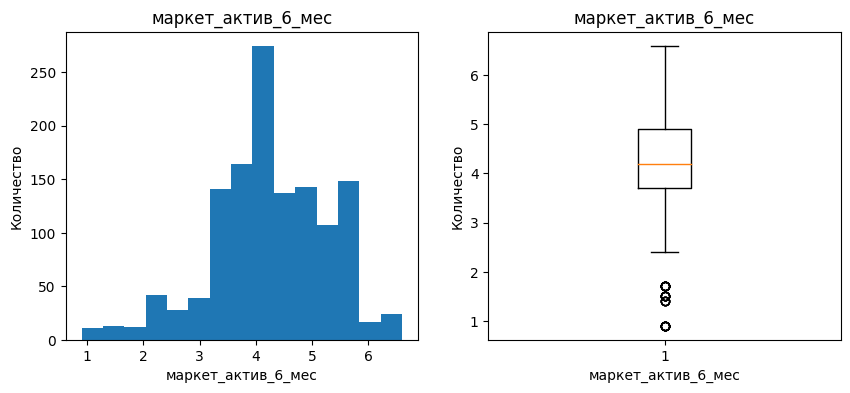

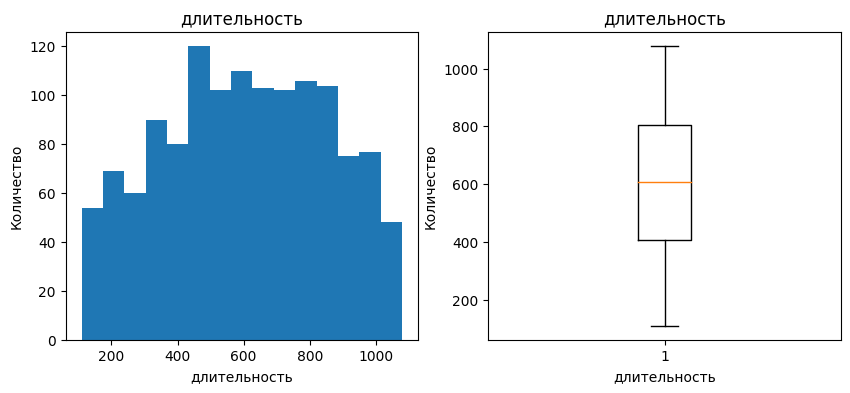

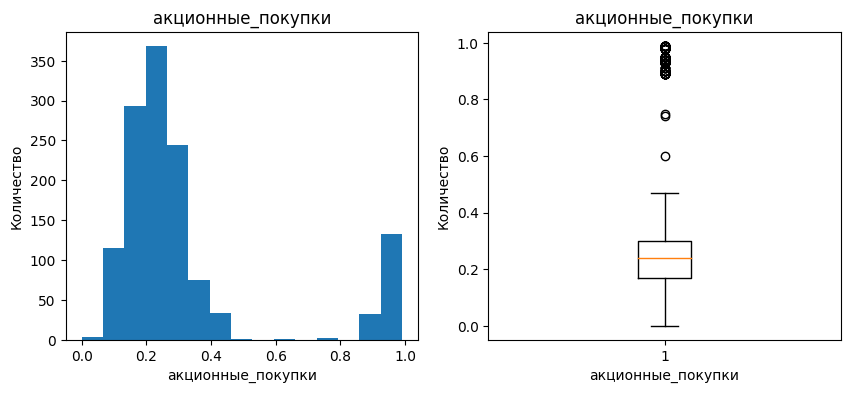

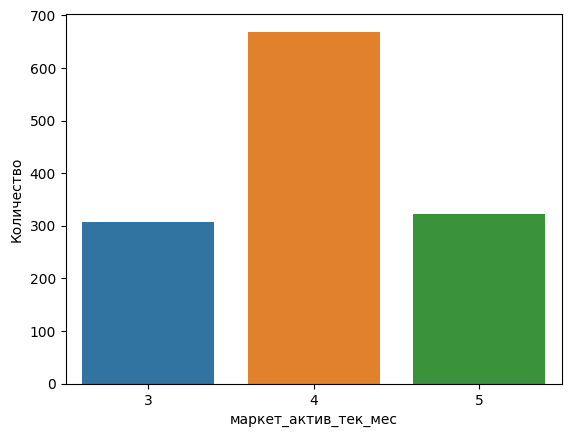

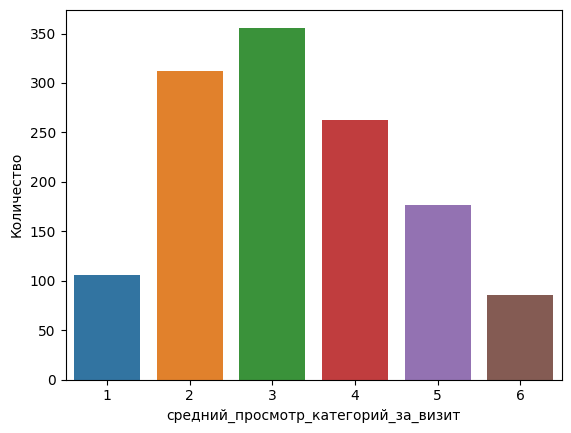

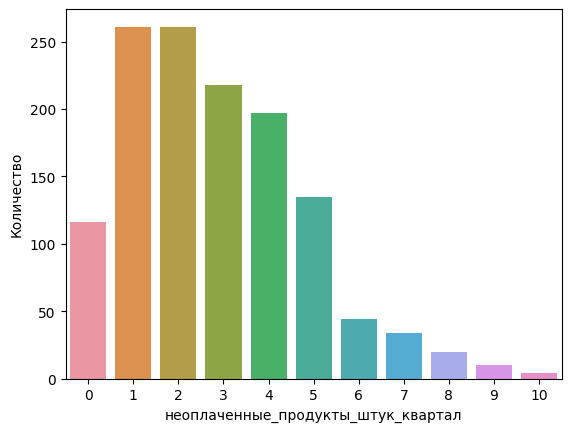

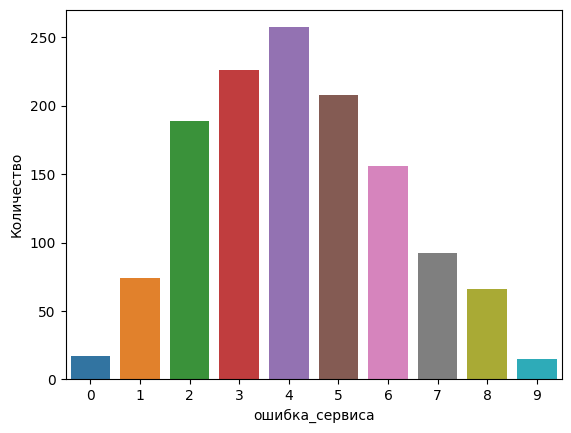

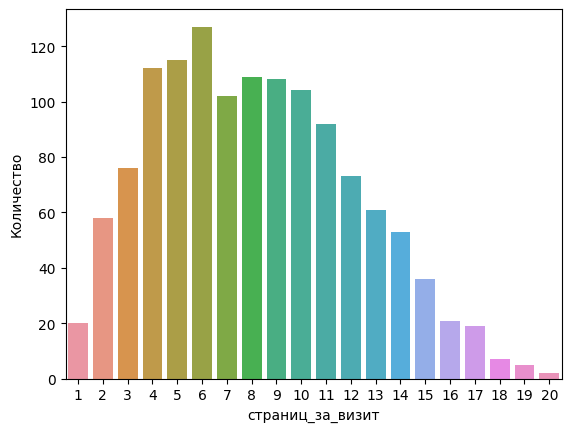

In [14]:
# гистограмма и диаграмма размаха количественных неприрывных признаков
for col, row in market_file_df[[
    'маркет_актив_6_мес', 
    'длительность', 
    'акционные_покупки',
]].items():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    
    axes[0].hist(row, bins=15)
    axes[0].set_title(col)
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Количество')
    
    axes[1].boxplot(row)
    axes[1].set_title(col)
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Количество')
    
plt.show()

# гистограмма и диаграмма размаха количественных дискретных признаков
for col, row in market_file_df[[
    'маркет_актив_тек_мес',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
]].items():
    sns.countplot(row, x=col)
    plt.xlabel(col)
    plt.ylabel('Количество')
    plt.show()


**Вывод:** Аномалий и выбросов в данных нет. 

Изучим категориальные признаки датафрейма `market_file_df`:

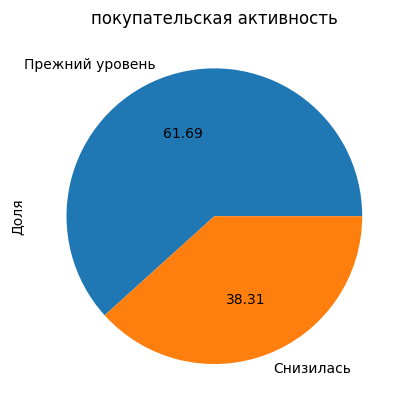

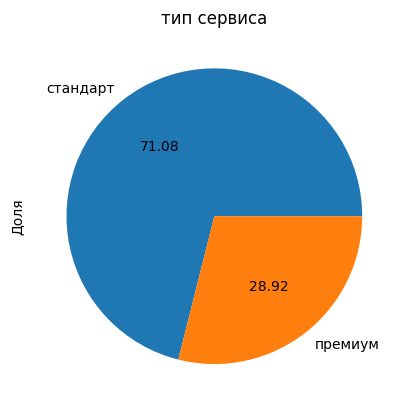

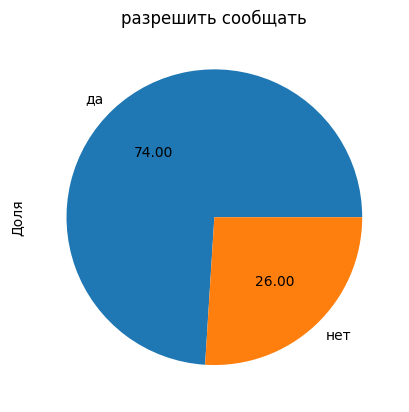

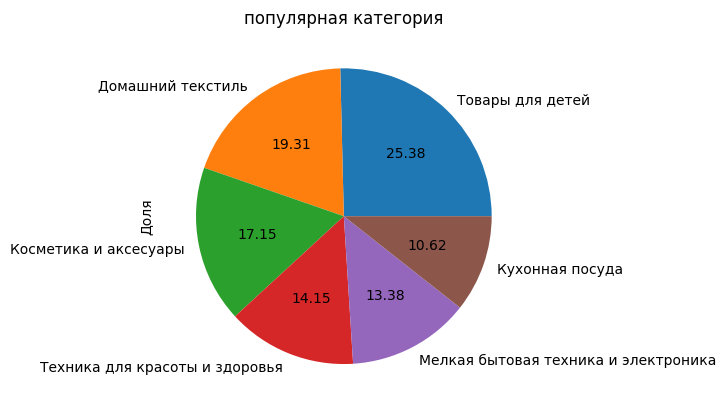

In [15]:
# категориальные признаки
for col, row in market_file_df[[
    'покупательская_активность',
    'тип_сервиса',
    'разрешить_сообщать',
    'популярная_категория',
]].items():
    row.value_counts().plot(
        kind='pie', 
        title=col.replace('_', ' '),
        ylabel='Доля',
        autopct='%.2f',
    )
    plt.show()

**Вывод:** среди категориальных данных аномальных значений не обнаружено.

Изучим количественные и категориальные признаки датафрейма `market_money_df`:

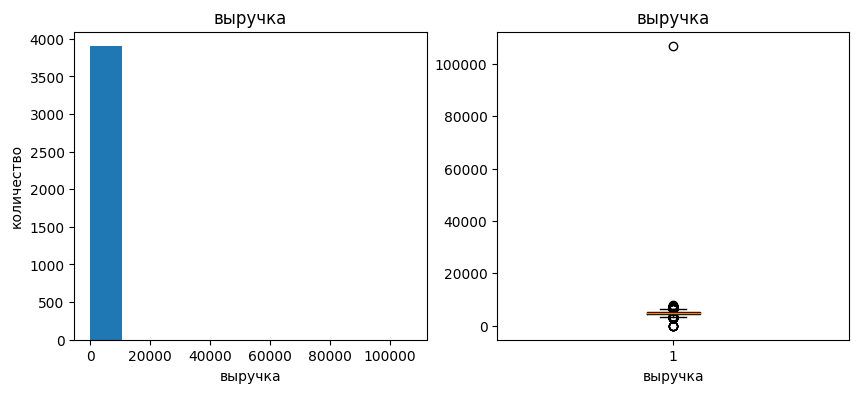

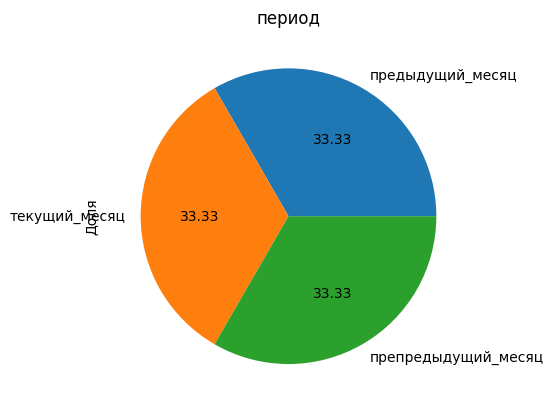

In [16]:
# гистограмма и диаграмма размаха количественных признаков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].hist(market_money_df['выручка'], bins=10)
axes[0].set_title('выручка')
axes[0].set_xlabel('выручка')
axes[0].set_ylabel('количество')
axes[1].boxplot(market_money_df['выручка'])
axes[1].set_title('выручка')
axes[1].set_xlabel('выручка')
plt.show()

# категориальные признаки
market_money_df['период'].value_counts().plot(
    kind='pie', 
    title='период',
    ylabel='Доля',
    autopct='%.2f',
)
plt.show()

В столбце `выручка` обнаружен выброс, сумма свыше 8000, а так же нулевая выручка. Изсключим аномальное значение и проверим изменения.

In [17]:
# отобразим аномальные значения
market_money_df.query('выручка > 8000 or выручка == 0')

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0
98,215380,текущий_месяц,106862.2


Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. А так же избавимся от выбросов.

In [18]:
# исключим аномальные значения из датафрейма
market_money_df = market_money_df.query('выручка < 8000')

# отбираем клиентов с покупательской активностью не менее 3-х месяцев
market_money_df = market_money_df.query('id not in [215348, 215357, 215359]')

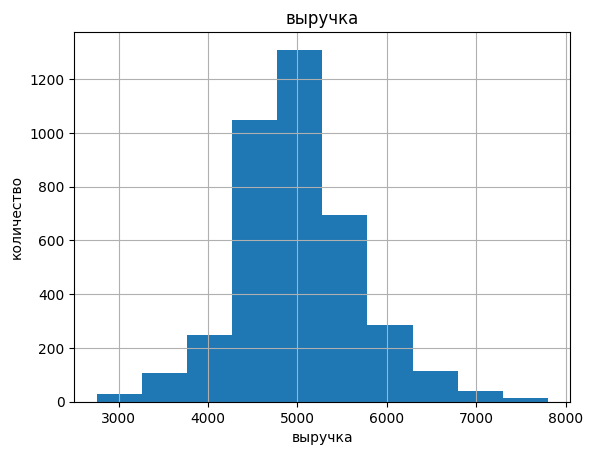

In [19]:
# построим гистограмму, чтобы убедиться что мы избавились от выбросов
market_money_df['выручка'].hist(bins=10)
plt.title('выручка')
plt.xlabel('выручка')
plt.ylabel('количество')
plt.show()

**Вывод:** в данных бы обнаружены и устранены выбросы. После изменений данные распределены нормально. 

Изучим количественные и категориальные признаки датафрейма `market_time_df`:

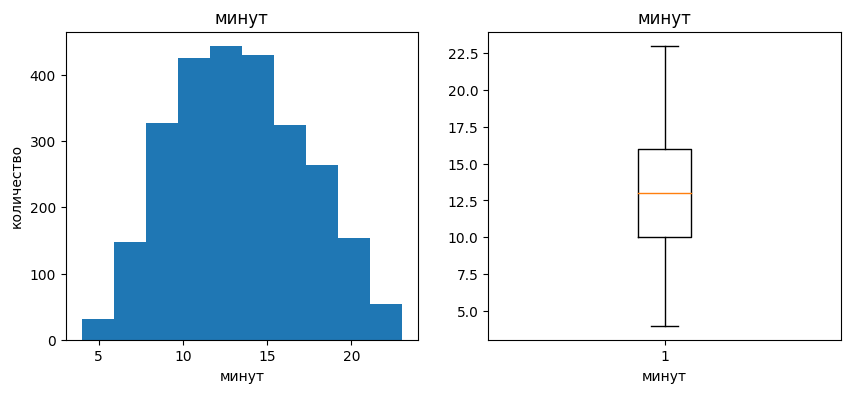

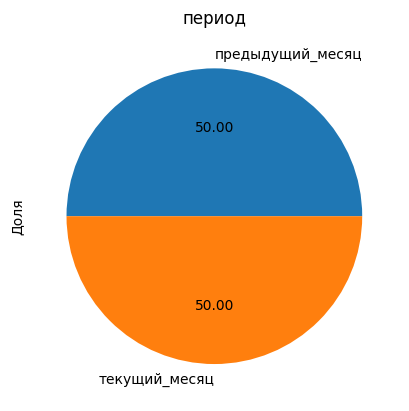

In [20]:
# гистограмма и диаграмма размаха количественных признаков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].hist(market_time_df['минут'], bins=10)
axes[0].set_title('минут')
axes[0].set_xlabel('минут')
axes[0].set_ylabel('количество')
axes[1].boxplot(market_time_df['минут'])
axes[1].set_title('минут')
axes[1].set_xlabel('минут')
plt.show()

# категориальные признаки
market_time_df['период'].value_counts().plot(
    kind='pie', 
    title='период',
    ylabel='Доля',
    autopct='%.2f',
)
plt.show()

**Вывод:** Аномалий и выбросов в данных не обнаружено.

Изучим количественные признаки датафрейма `money_df`:

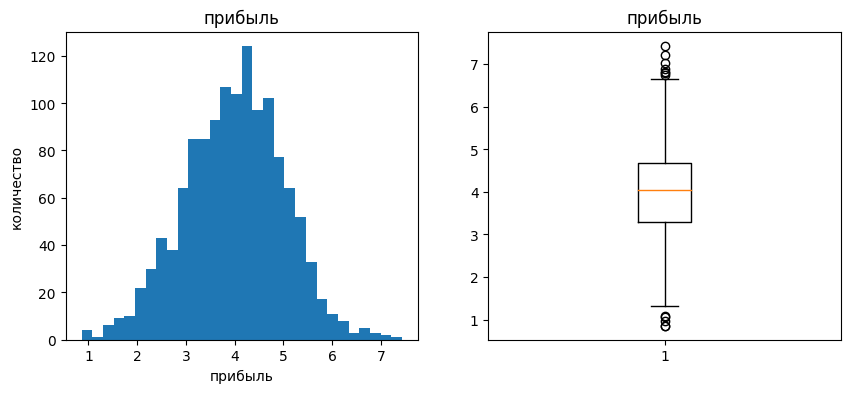

In [21]:
# гистограмма и диаграмма размаха количественных признаков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].hist(money_df['прибыль'], bins=30)
axes[0].set_title('прибыль')
axes[0].set_xlabel('прибыль')
axes[0].set_ylabel('количество')
axes[1].boxplot(money_df['прибыль'])
axes[1].set_title('прибыль')
plt.show()

**Вывод:** Аномалий и выбросов в данных не обнаружено. Данные распределены нормально.

**Общий вывод по этапу "исследовательский анализ данных":**
- произведен анализ категориальных и количественных признаков в данных;
- в результате анализа найдены и устранены выбросы в датафрейме `market_money_df`;
- отобраны клиенты с покупательской активностью не менее трёх месяцев.

## Объединение таблиц

Объединим таблицы `market_file_df`, `market_money_df` и `market_time_df` по полю `id`:

In [22]:
# разделим данные на две категории (предыдущий_месяц и текущий_месяц) для датафреймов market_money_df и market_time_df
new_market_money_df = market_money_df.pivot_table(
    index='id',
    columns=['период'],
    values='выручка',
    aggfunc='sum',
)

new_market_money_df.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
new_market_money_df.fillna(0)

new_market_time_df = market_time_df.pivot_table(
    index='id',
    columns=['период'],
    values='минут',
    aggfunc='sum',
)
new_market_time_df.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
new_market_time_df.fillna(0)

# определим признаки согласно группировки "Финансовое поведение"
new_market_money_df['разница_выручки_текущего_и_предыдущего_месяцев'] = new_market_money_df['выручка_текущий_месяц'] - new_market_money_df['выручка_предыдущий_месяц']
new_market_money_df['разница_выручки_предыдущего_и_препредыдущего_месяцев'] = new_market_money_df['выручка_предыдущий_месяц'] - new_market_money_df['выручка_препредыдущий_месяц']
new_market_money_df = new_market_money_df.drop(columns=['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц'], axis=1)
 
# объединим таблицы и проверим результат объеденения
market_file_df = market_file_df.set_index('id').join([new_market_money_df, new_market_time_df])

# определим признаки согласно группировки "Поведение на сайте"
market_file_df['среднее_количество_минут_за_месяц'] = ((market_file_df['минут_предыдущий_месяц'] + market_file_df['минут_текущий_месяц']) / 2).round(2)
market_file_df['длительность_в_прошлом_году'] = market_file_df['длительность'].apply(visit_times_last_year)
market_file_df['среднее_время_на_сайте_за_прошлый_год'] = market_file_df['длительность_в_прошлом_году'] * market_file_df['среднее_количество_минут_за_месяц']
market_file_df = market_file_df.drop(columns=['длительность_в_прошлом_году'], axis=1)

market_file_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 19 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   покупательская_активность                             1300 non-null   object 
 1   тип_сервиса                                           1300 non-null   object 
 2   разрешить_сообщать                                    1300 non-null   object 
 3   маркет_актив_6_мес                                    1300 non-null   float64
 4   маркет_актив_тек_мес                                  1300 non-null   int64  
 5   длительность                                          1300 non-null   int64  
 6   акционные_покупки                                     1300 non-null   float64
 7   популярная_категория                                  1300 non-null   object 
 8   средний_просмотр_категорий_за_визит                

**Общий вывод по этапу "объединение таблиц":**
- были объединим таблицы `market_file_df`, `market_money_df` и `market_time_df`;
- данные из таблиц `market_money_df` и `market_time_df` были разделены по периодам и выделены в отдельные признаки;
- среднее время проведенное на сайте осталось тем же;
- дополнительные признаки для обучения помогут разработать модель более высокого качества.

## Корреляционный анализ

Коэффициент корреляции Пирсона/Спирмена обычно используется для непрерывных данных, в то время как $\phi$-коэффициент применяется для номинальных или категориальных переменных, поэтому будем использовать **$\phi$-коэффициент** корреляции. 
Рассчитаем кофициент корреляции для столбцов датафрейма `ferma_main_df`:

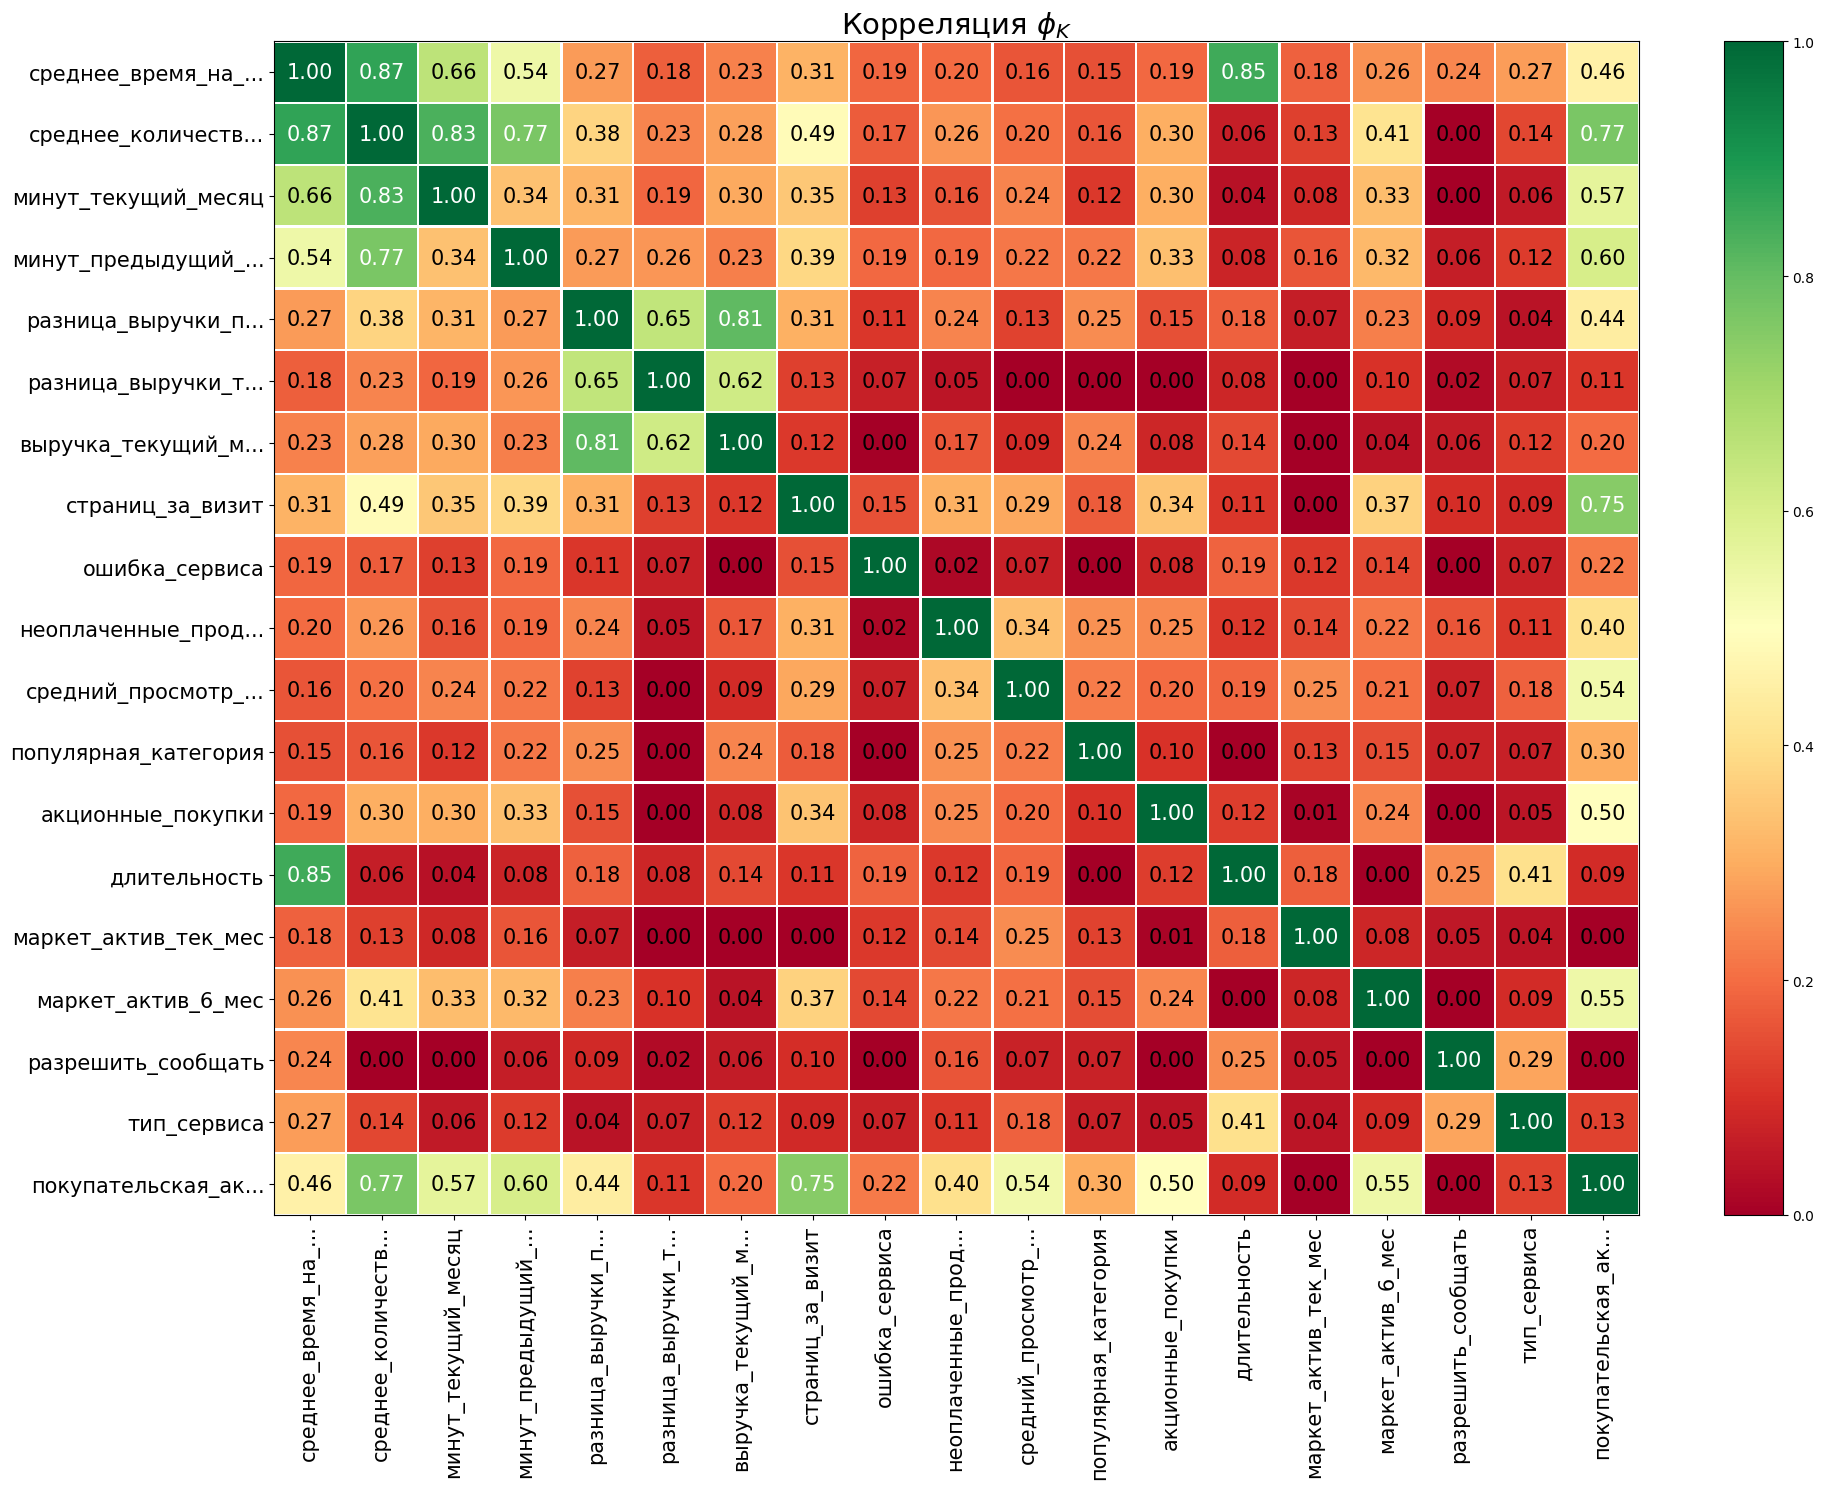

In [23]:
# создаём список с наименованиями непрерывных признаков
interval_cols = [
    'маркет_актив_6_мес', 
    'длительность', 
    'акционные_покупки', 
    'выручка_текущий_месяц',
    'разница_выручки_текущего_и_предыдущего_месяцев',
    'разница_выручки_предыдущего_и_препредыдущего_месяцев',
    'среднее_количество_минут_за_месяц',
    'среднее_время_на_сайте_за_прошлый_год',
]

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(
    market_file_df, 
    interval_cols=interval_cols
)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, 
    vmax=1, 
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. В данном случае мы имеем высокую корреляцию входных признаков между:
- `среднее_количество_минут_за_месяц` и `среднее_время_на_сайте_за_прошлый_год`- 0.89;
- `длительность` и `среднее_время_на_сайте_за_прошлый_год` - 0.85:
- `минут_текущий_месяц` и `среднее_количество_минут_за_месяц` - 0.83;
- `выручка_текущий_месяц` и `разница_выручки_предыдущего_и_препредыдущего_месяцев` - 0.81;
- `минут_предыдущий_месяц` и `среднее_количество_минут_за_месяц` - 0.77.

При наличии высокой корреляции входных признаков в данном случае мультиколлинеарность отсутствует.

Присутствует высокая корреляция целевого признака `покупательская_активность` со следующими входными признаками:
- `среднее_количество_минут_за_месяц` - 0.77;
- `страниц_за_визит` - 0.75;
- `минут_предыдущий_месяц` - 0.6;
- `минут_текущий_месяц` - 0.57.

Посмотрим на характер связи входных признаков, с высокой сорреляцией. 

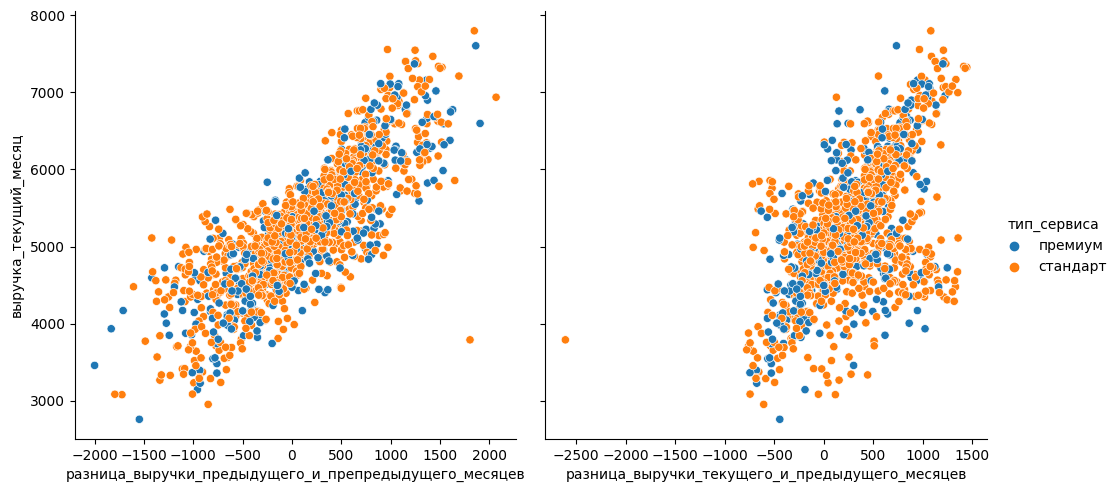

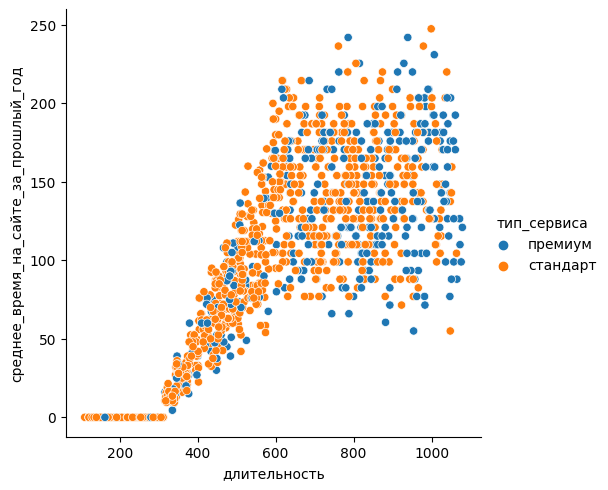

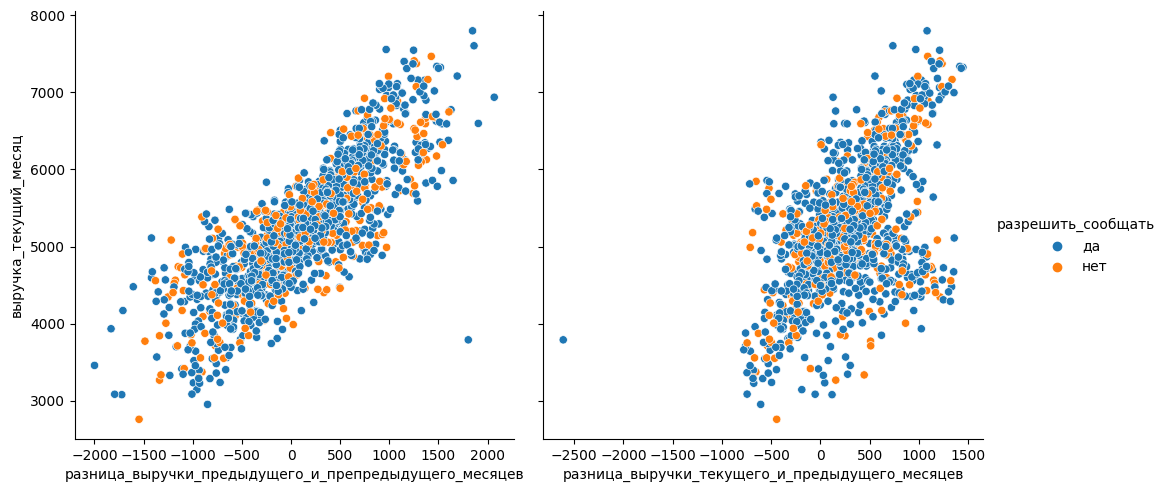

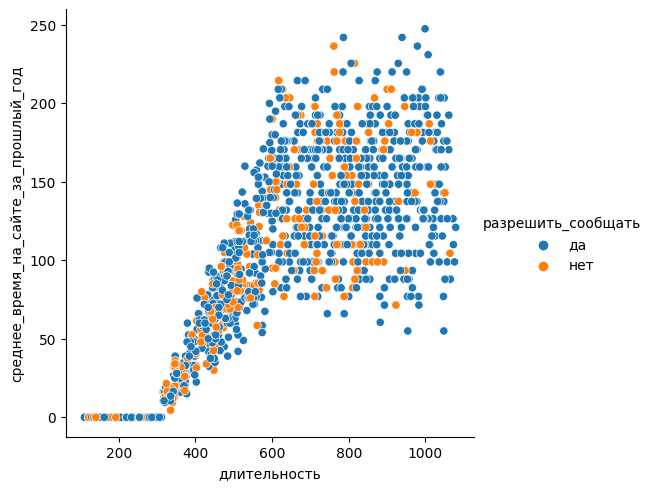

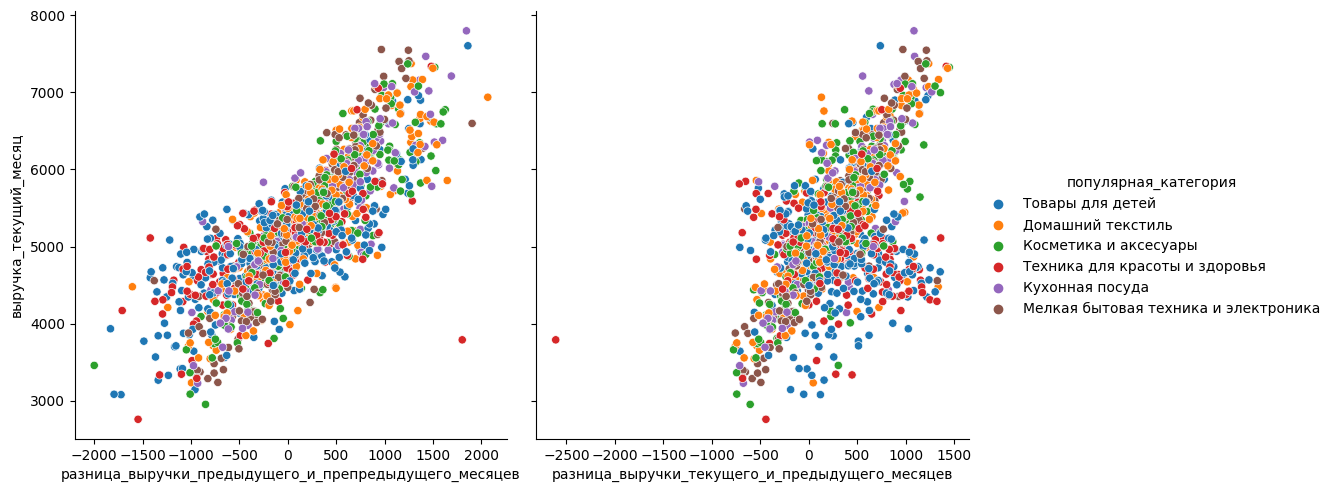

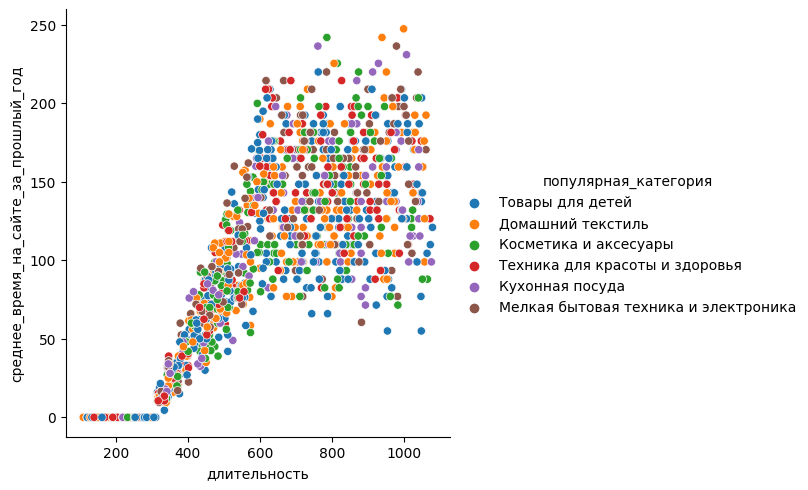

In [24]:
for col_cat in [
    'тип_сервиса',
    'разрешить_сообщать',
    'популярная_категория',
]:
    g = sns.PairGrid(
        market_file_df, 
        hue=col_cat,
        y_vars='выручка_текущий_месяц', 
        x_vars=[
            'разница_выручки_предыдущего_и_препредыдущего_месяцев', 
            'разница_выручки_текущего_и_предыдущего_месяцев',
        ],
        height=5,
    )
    g.map(sns.scatterplot)
    g.add_legend()

    g = sns.PairGrid(
        market_file_df, 
        hue=col_cat,
        y_vars='среднее_время_на_сайте_за_прошлый_год', 
        x_vars=[
            'длительность',
        ],
        height=5,
    )
    g.map(sns.scatterplot)
    g.add_legend()

plt.show()

**Общий вывод по этапу "корреляционный анализ":**
- входные признаки не мультиколлинеарны;
- в данных линейно связанны:
    - `выручка_текущий_месяц` и `разница_выручки_предыдущего_и_препредыдущего_месяцев`;
    - `выручка_текущий_месяц` и `разница_выручки_текущего_и_предыдущего_месяцев`;
    - `длительность` и `среднее_время_на_сайте_за_прошлый_год`.

## Использование пайплайнов

### Подготовка данных

In [25]:
RANDOM_STATE = 42
TEST_SIZE = 0.25


# разделим данные на тренировочную и тестовую выборки
X = market_file_df.drop(['покупательская_активность'], axis=1)
y = market_file_df['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
)

In [26]:
## Отбор признаков

# создаём списки с названиями признаков
ohe_columns = ['популярная_категория',]
ord_columns = [
    'тип_сервиса', 
    'разрешить_сообщать',
]
num_columns = [
    'маркет_актив_6_мес', 
    'маркет_актив_тек_мес', 
    'длительность', 
    'акционные_покупки', 
    'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
    'разница_выручки_текущего_и_предыдущего_месяцев',
    'разница_выручки_предыдущего_и_препредыдущего_месяцев',
    'выручка_текущий_месяц',
    'среднее_время_на_сайте_за_прошлый_год',
    'минут_предыдущий_месяц',
    'минут_текущий_месяц',
]

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
])

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['стандарт', 'премиум'], 
            ['нет', 'да'],
        ], 
        handle_unknown='use_encoded_value', 
        unknown_value=np.nan
    )),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns),
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE)),
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11),
        'models__min_samples_leaf': range(1, 11),
        'models__min_samples_split': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'], 
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l2',
        )],
        'models__C': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],  
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1, 11),
        'models__kernel': ['rbf','sigmoid', 'linear', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
]

### Обучение моделей

**Выбор метрики:** будем считать метрику `ROC-AUC`. так как она отлично подходит для бинарной классификации с несбалансированной выборкой.

In [27]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_.round(3))

# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)

y_test_pred_ = [1 if obj == 'Прежний уровень' else 0 for obj in y_test_pred]
y_test_ = [1 if obj == 'Прежний уровень' else 0 for obj in y_test]

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_, y_test_pred_).round(2)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
           

## Анализ важности признаков

 Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP.

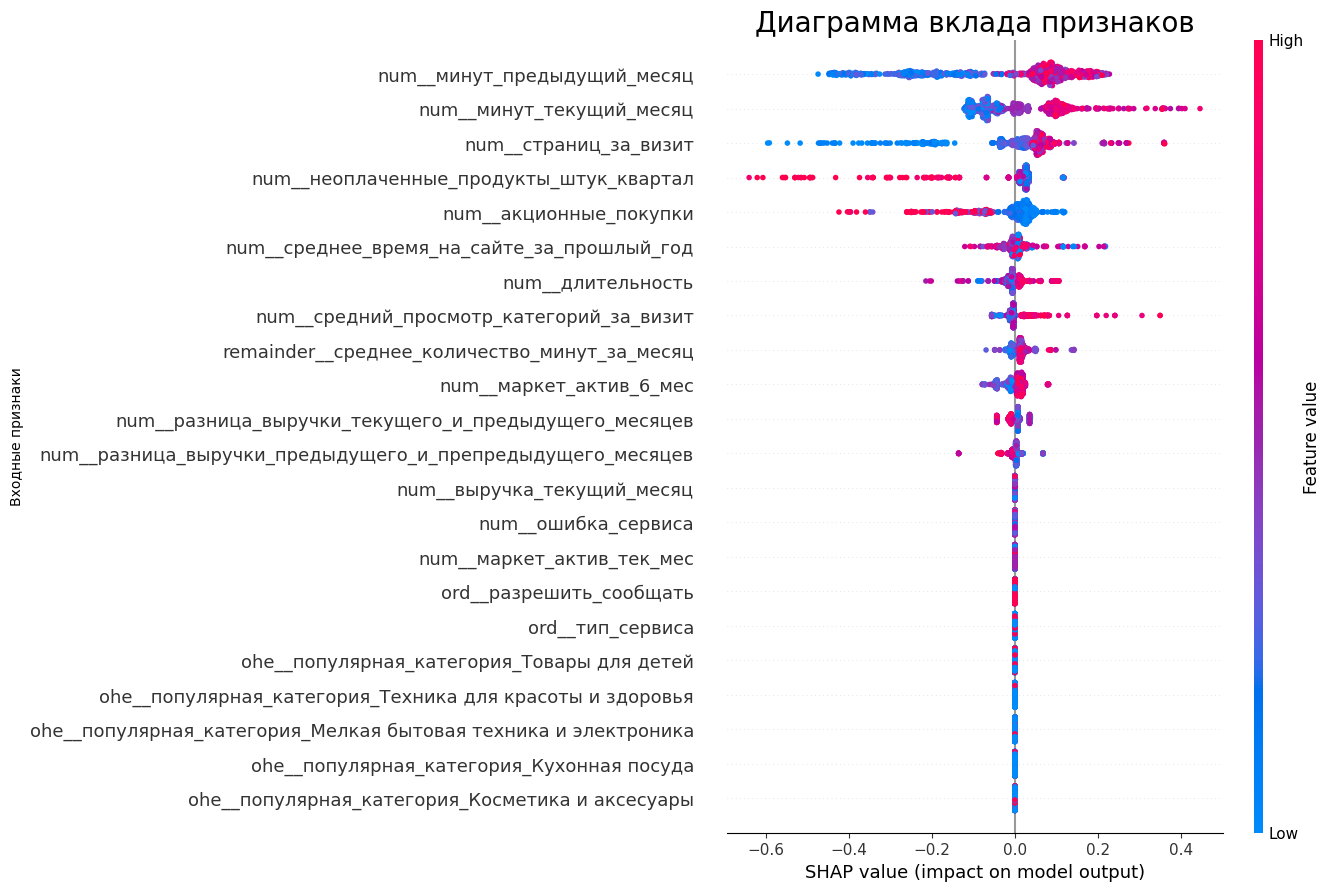

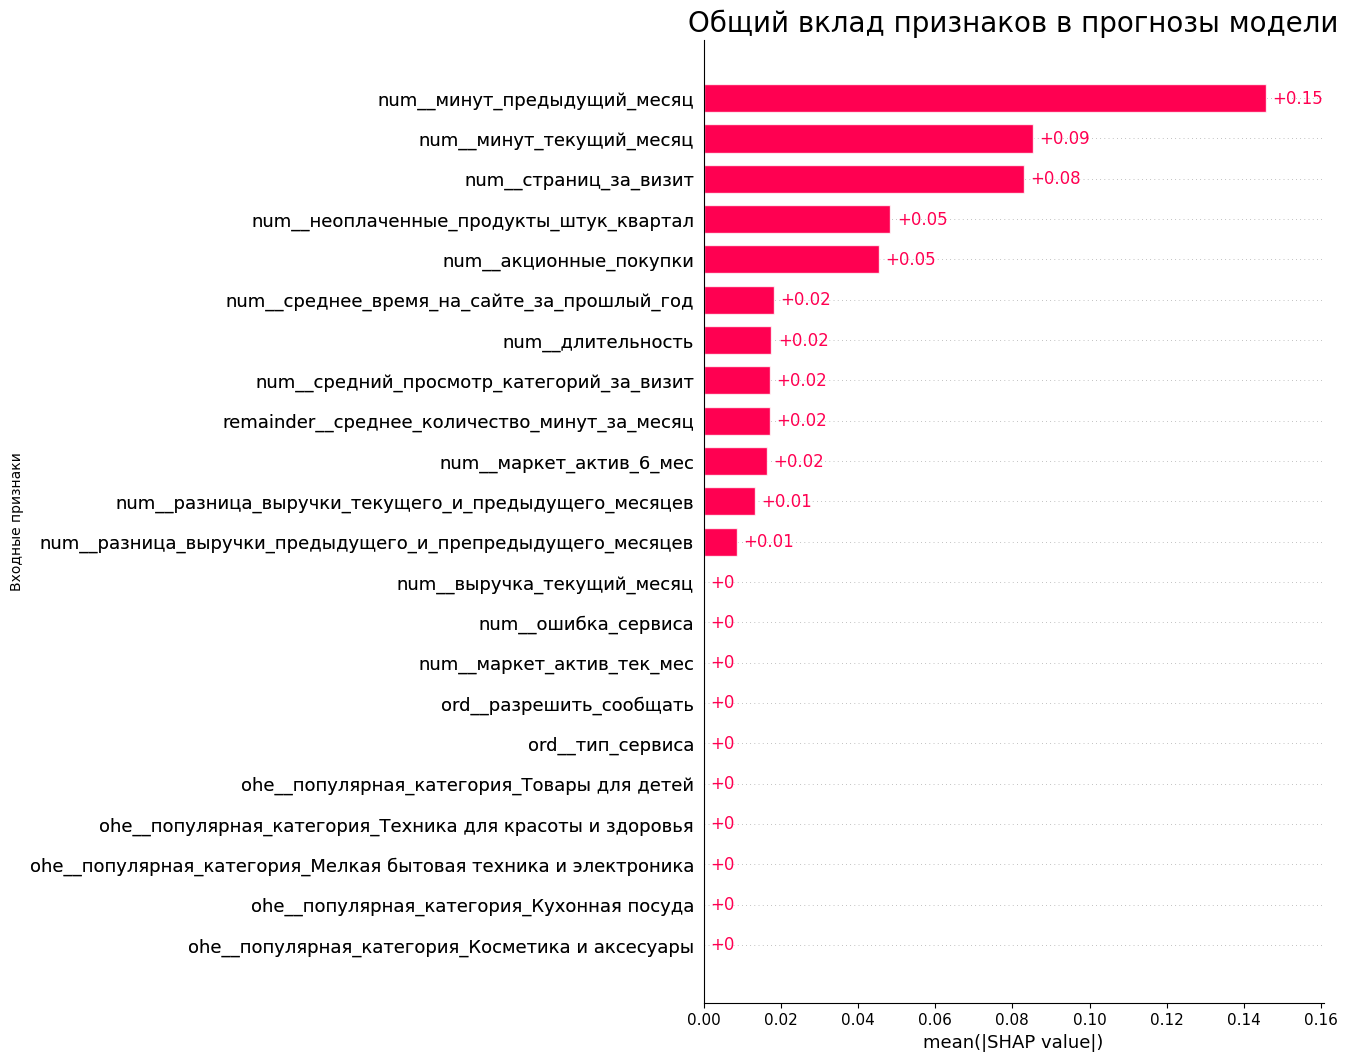

In [28]:
best_model = randomized_search.best_estimator_['models']
preprocessor = randomized_search.best_estimator_['preprocessor']
feature_names = preprocessor.get_feature_names_out()

X_train_encoded = preprocessor.transform(X_train)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_train_encoded)[:,:,0]
shap_values.feature_names = feature_names

fig, ax = plt.gcf(), plt.gca()
ax.set_title('Диаграмма вклада признаков', fontdict={"size": 20})
ax.set_ylabel('Входные признаки')

shap.plots.beeswarm(
    shap_values=shap_values,
    max_display=50,
)

fig, ax = plt.gcf(), plt.gca()
ax.set_title('Общий вклад признаков в прогнозы модели', fontdict={"size": 20})
ax.set_ylabel('Входные признаки')
shap.plots.bar(
    shap_values=shap_values,
    max_display=50,
)

**Выводы о значимости признаков:**
- признаки мало значимы для модели:
    - `num__выручка_текущий_месяц`;
    - `num__маркет_актив_тек_мес`;
    - `num__маркет_актив_6_мес`;
    - `ord__разрешить_сообщать`;
    - `ord__тип_сервиса`;
    - `ohe__популярная_категория_Косметика и аксесуары`;
    - `ohe__популярная_категория_Кухонная посуда`;
    - `ohe__популярная_категория_Мелкая бытовая техника и электроника`;
    - `ohe__популярная_категория_Техника для красоты и здоровья`;
    - `ohe__популярная_категория_Товары для детей`.
- признаки сильнее всего влияют на целевой:
    - `num__минут_предыдущий_месяц`;
    - `num__страниц_за_визит`;
    - `num__акционные_покупки`;
    - `num__минут_текущий_месяц`;
    - `num_неоплаченные_продукты_штук_квартал`;
    - `num_средний_просмотр_категорий_за_визит`.
- высокое значение `num__неоплаченные_продукты_штук_квартал` снижает вероятность принадлежности к классу 1.

## Сегментация покупателей

Взглянем еще раз на гистограмму `money_df`.

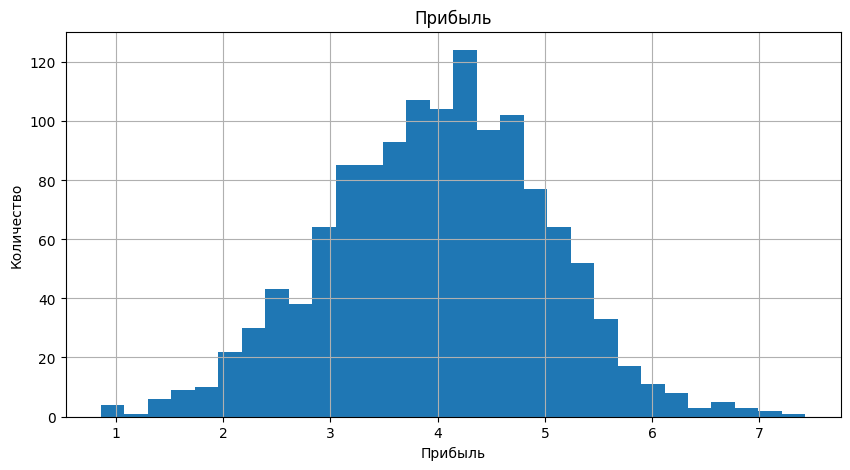

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

In [29]:
plt.figure(figsize=(10, 5))
money_df['прибыль'].hist(bins=30)
plt.title('Прибыль')
plt.xlabel('Прибыль')
plt.ylabel('Количество')
plt.show()

money_df['прибыль'].describe()

Прибыль распределена нормально, что подтверждает близость значений медианы и среднего.

Перед сегментацией объеденим 2-е таблицы `market_file_df` и `money_df`.

In [30]:
new_market_file_df = market_file_df.merge(money_df, how='left', on='id')

In [31]:
new_market_file_df.sort_values(by='прибыль', ascending=False).head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,ошибка_сервиса,страниц_за_визит,выручка_текущий_месяц,разница_выручки_текущего_и_предыдущего_месяцев,разница_выручки_предыдущего_и_препредыдущего_месяцев,минут_предыдущий_месяц,минут_текущий_месяц,среднее_количество_минут_за_месяц,среднее_время_на_сайте_за_прошлый_год,прибыль
53,215401,Снизилась,премиум,да,3.4,5,339,0.30,Косметика и аксесуары,2,...,3,4,6065.9,517.4,715.5,10,8,9.0,9.0,7.43
1026,216374,Прежний уровень,стандарт,да,4.4,4,1024,0.27,Косметика и аксесуары,3,...,4,8,4464.4,-165.1,-340.5,11,13,12.0,132.0,7.21
817,216165,Прежний уровень,стандарт,нет,5.4,4,142,0.15,Домашний текстиль,5,...,6,10,5383.0,195.0,75.0,11,11,11.0,0.0,7.02
215,215563,Снизилась,премиум,да,3.9,5,956,0.35,Косметика и аксесуары,2,...,6,7,6114.5,78.0,1051.5,10,9,9.5,104.5,6.88
920,216268,Прежний уровень,стандарт,да,4.1,4,327,0.19,Товары для детей,3,...,0,12,4925.8,1034.8,-1044.0,17,16,16.5,16.5,6.81


Построитм графики для входных признаков которые сильнее других влияют на целевой в разрезе прибыли.

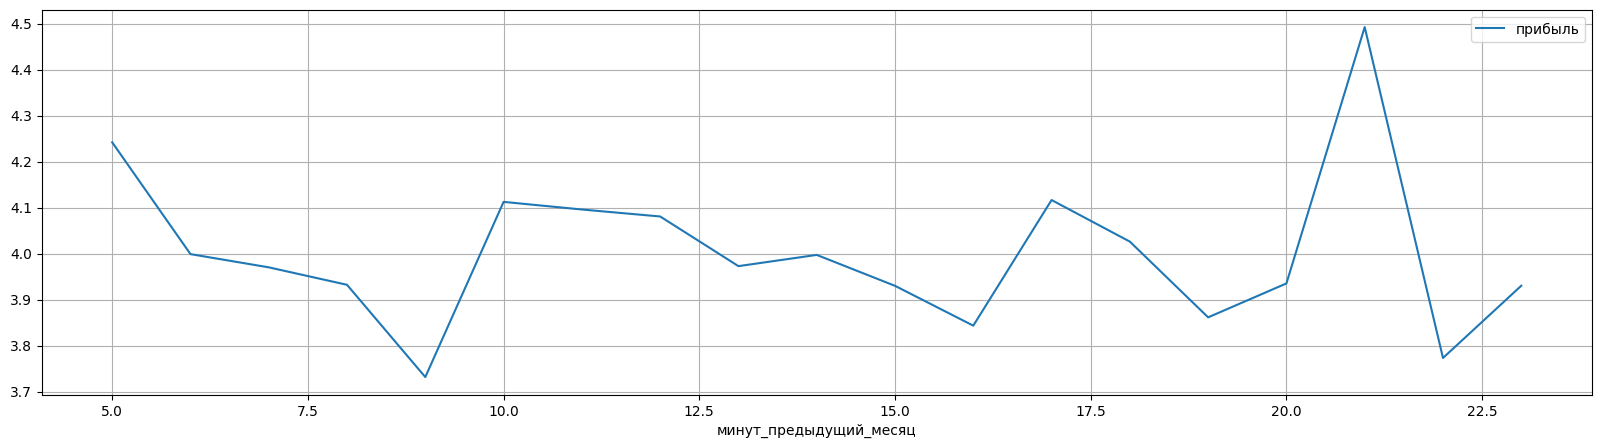

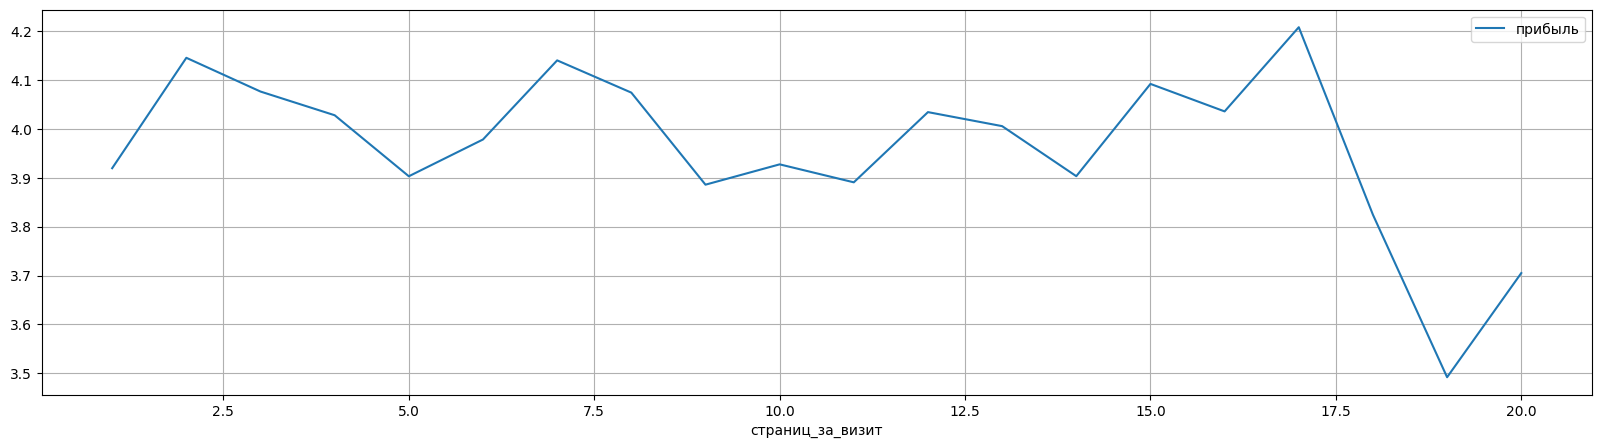

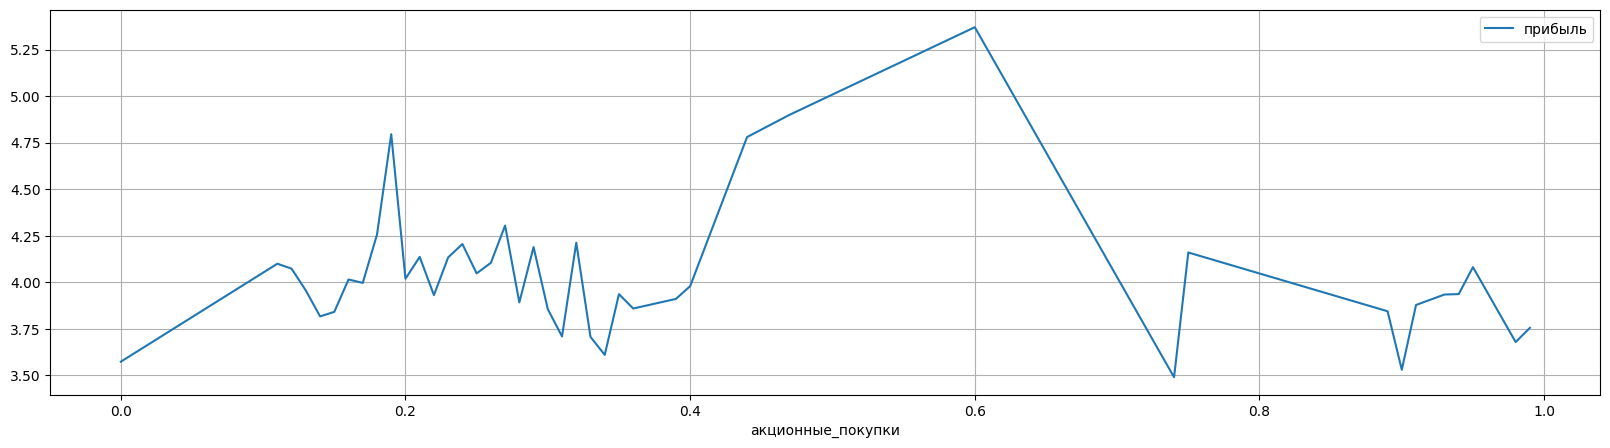

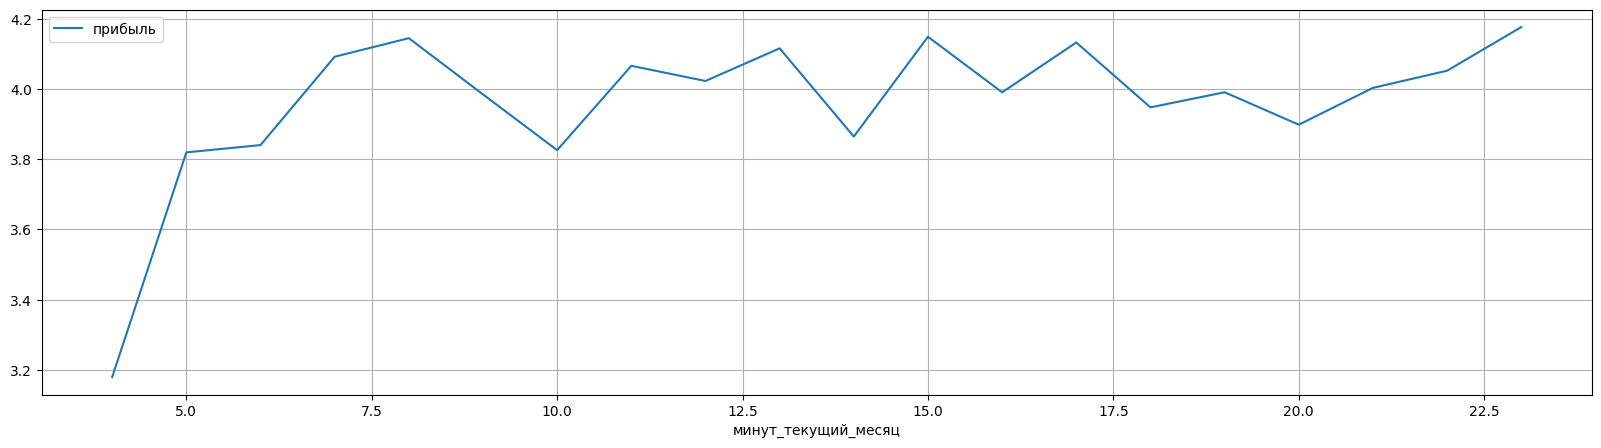

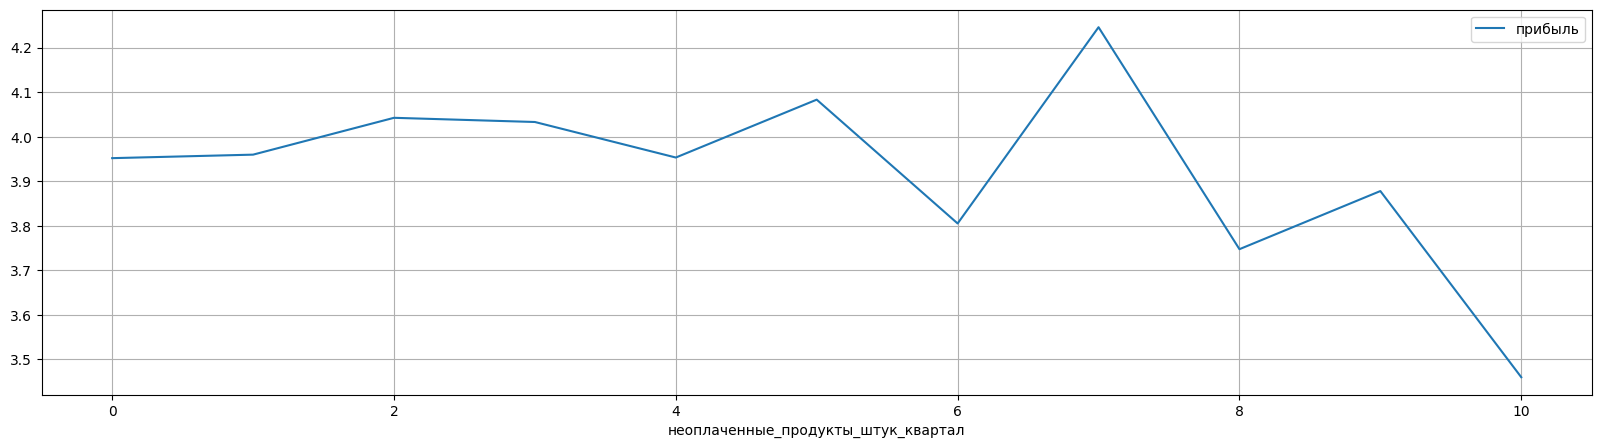

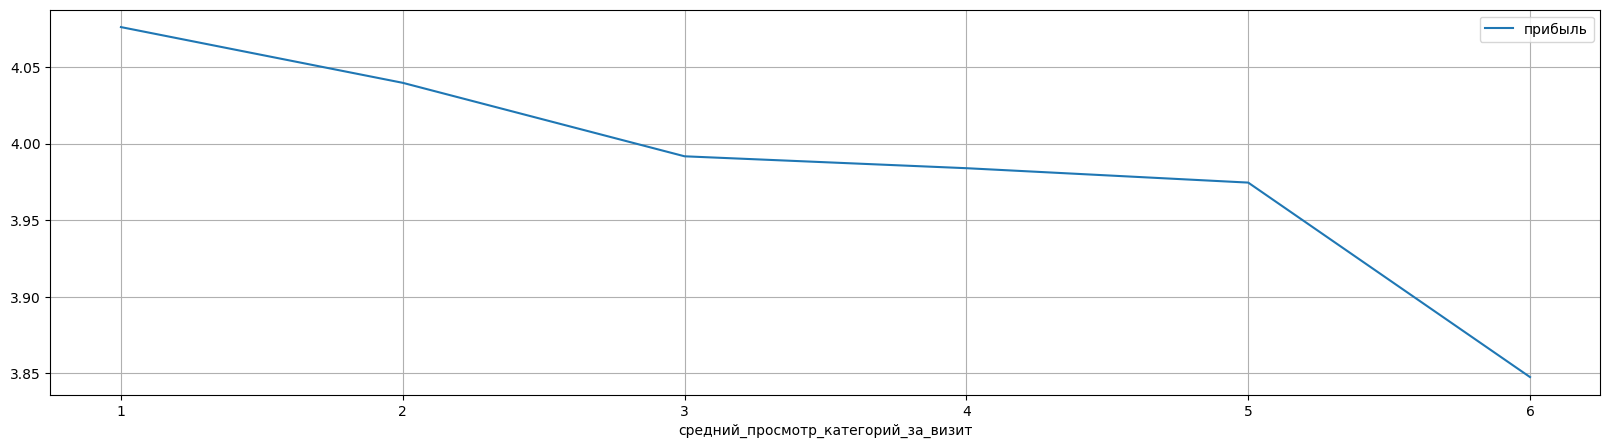

In [32]:
for idx in [
    'минут_предыдущий_месяц',
    'страниц_за_визит',
    'акционные_покупки',
    'минут_текущий_месяц',
    'неоплаченные_продукты_штук_квартал',
    'средний_просмотр_категорий_за_визит',
]:
    new_market_file_df.pivot_table(
        index=idx,
        values='прибыль',
        aggfunc='mean',
    ).plot(figsize=(20, 5), grid=True)
plt.show()

Можно выделить следующие особенности:
- `акционные_покупки` - можно выделить сегмент c высокой прибылью от 0.5 до 0.6 акционных покупок;
- `средний_просмотр_категорий_за_визит` - можно выделить 3-и сегмента:
    - 1 сегмент - от 1 до 3 категорий за визит (высокая прибыль);
    - 2 сегмент - от 3 до 5 категорий за визит (средняя прибыль);
    - 3 сегмент - от 5 до 6 категорий за визит (низкая прибыль).

**Вывод:**
- Сегмент покупателей совершающих акционные покупки от 0.5 до 0.6 от общего числа покупок, а так-же просматривающая от 1 до 3 категорий за визит - приносит наиболее высокую прибыль.
- Для дополнительного исследования можно взять сегмент покупателей где доля акционных покупок составляет меньше 0.5 а так же средний просмотр категорий больше 3-х.
- Возможно стоит активнее информировать покупателей об акциях, чтобы доля акционных покупок росла, что повысит доход. 
- Так же можно сосредодочиться на индивидуальных предложениях для покупателей, возможно следует упростить навигацию на сайте, чтобы проще было добраться до интересующей категории товара - об этом нам говорит высокая доходность у покупателей посещающих от 1 до 3 категорий за визит.

## Общий вывод

- Цель работы — разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность;
- Для исследования были предоставлены следующие данные:
    - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении;
    - данные о том сколько покупатель всего потратил за период взаимодействия с сайтом;
    - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода;
    - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- В результате предобработки данных избавились от дубликатов и пропусков. Дубликаты и пропуски искажают результаты машинного обучения;
- Для поиска лучшей модели были выполнены следующие этапы:
    - `Исследовательский анализ данных` - проанализированы данные, обнаружены и устранены выбросы и аномалии в данных;
    - `Объединение таблиц` - объединение таблиц и добавление новых параметров, которые должны улучшить модель;
    - `Корреляционный анализ` - в результате корреляционного анализа были сделаны выводы о связи между входными признаками и выводы о мультиколлинеарности;
    - `Использование пайплайнов` - на этом этапе было проанализированно несколько моделей с различными гиперпараметрами: 
        - `KNeighborsClassifier` - метод k-ближайших соседей;
        - `DecisionTreeClassifier` - дерево решений;
        - `LogisticRegression` - логистическая регрессия;
        - `SVC` - метод опорных векторов.
- В результате лучшая модель оказалась `DecisionTreeClassifier` (дерево решений);
- В результате исследований, можно сделать вывод, что:
    - Стоит активнее информировать покупателей об акциях, чтобы доля акционных покупок росла, что повысит доход. 
    - Возможно следует упростить навигацию на сайте, чтобы проще было добраться до интересующей категории товара - об этом нам говорит высокая доходность у покупателей посещающих от 1 до 3 категорий за визит.